In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import tensorflow as tf
import autokeras as ak

In [5]:
#load data
from BIAS.SB_Test_runner import get_scens_per_dim, get_simulated_data

rep = 10000
n_samples = 100

scenes = get_scens_per_dim()
per_label = {"unif":0, "centre":0, "bounds":0, "gaps/clusters":0, "disc":0}
X = []
y = []
for scene in scenes:
    label = scene[0]
    kwargs = scene[1]
    if (label == "unif"):
        rep1 = 4 * rep
    elif (label in ["trunc_unif", "cauchy", "norm"]):
        rep1 = int(rep / 32)
    elif (label in ["bound_thing","inv_norm", "inv_cauchy"]):
        rep1 = int(rep / 48)
    elif (label in ["clusters","gaps", "part_unif"]):
        rep1 = int(rep / 67)
    elif (label in ["spikes", "shifted_spikes"]):
        rep1 = int(rep / 42)
    data = get_simulated_data(label, rep=rep1, n_samples = n_samples, kwargs=kwargs)
    for r in range(rep1):
        X.append(np.sort(data[:,r]))
    if (label in ["trunc_unif", "cauchy", "norm"]):
        label = "centre"
    elif (label in ["bound_thing","inv_norm", "inv_cauchy"]):
        label = "bounds"
    elif (label in ["gaps", "part_unif", "clusters"]):
        label = "gaps/clusters"
    elif (label in ["spikes", "shifted_spikes"]):
        label = "disc"
    per_label[label] += rep1
    y.extend([label]*rep1)

print(per_label)
X = np.array(X)
int_y, targetnames= pd.factorize(y)

cat_y = to_categorical(int_y)

{'unif': 40000, 'centre': 9984, 'bounds': 9984, 'gaps/clusters': 9983, 'disc': 9996}


In [6]:

print(X.shape)
print(int_y.shape)
print(cat_y.shape)

print(targetnames)

print(y[0])
print(int_y[0])
print(cat_y[0])


(79947, 100)
(79947,)
(79947, 5)
['unif' 'centre' 'disc' 'bounds' 'gaps/clusters']
unif
0
[1. 0. 0. 0. 0.]


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, cat_y, test_size=0.2, random_state=42, stratify=int_y)

if True:
    clf = ak.StructuredDataClassifier(
        max_trials=10,
        overwrite=True,
    )
else:
    clf = ak.ImageClassifier(
        max_trials=5,
        overwrite=True,
    )
    X_train = np.expand_dims(X_train, axis=2)
# Search for the best model with EarlyStopping.
cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5),
]

clf.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    callbacks=cbs
)
# Evaluate on the testing data.
print(
    "Accuracy: {accuracy}".format(
        accuracy=clf.evaluate(x=X_test, y=y_test)
    )
)

#interesting option from autokeras.image.image_supervised import ImageClassifier1D
#model = ImageClassifier1D(verbose=True)

#X_train = np.expand_dims(X, axis=2)
#model.fit(X_train, Y, time_limit=1 * 60 * 60)

Trial 1 Complete [00h 03m 52s]
val_loss: 0.6291046738624573

Best val_loss So Far: 0.6291046738624573
Total elapsed time: 00h 03m 52s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
resnet            |vanilla           |image_block_1/block_type
True              |True              |image_block_1/normalize
True              |False             |image_block_1/augment
True              |None              |image_block_1/image_augmentation_1/horizontal_flip
True              |None              |image_block_1/image_augmentation_1/vertical_flip
0                 |None              |image_block_1/image_augmentation_1/contrast_factor
0                 |None              |image_block_1/image_augmentation_1/rotation_factor
0.1               |None              |image_block_1/image_augmentation_1/translation_factor
0                 |None              |image_block_1/image_augmentation_1/zoom_factor
False             |None              |image_block_1/res_net_block_1/pr

KeyboardInterrupt: 

In [ ]:
model = clf.export_model()
model.summary()
model.save("model_new_data_cnn.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 multi_category_encoding (Mu  (None, 100)              0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 100)              201       
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
class newmodel(MLPClassifier):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y = self.model.predict(X)
        return np.argmax(y, axis=1)


63/63 [==============================] - 0s 1ms/step


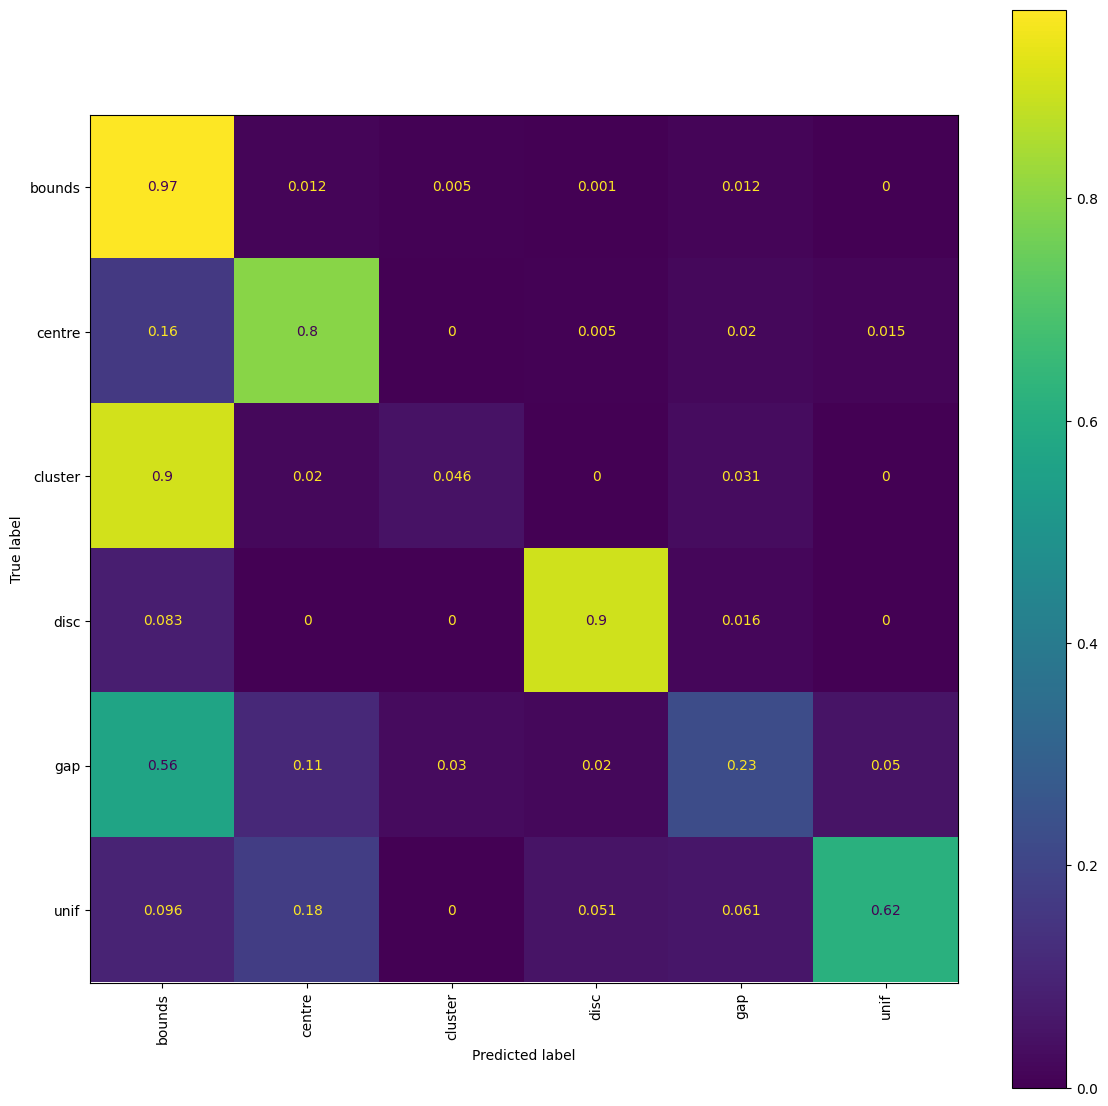

In [ ]:
model1 = newmodel(model)
fig, ax = plt.subplots(figsize=(14, 14))
plot_confusion_matrix(model1, X_test, np.argmax(y_test, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames)), ax=ax) 
plt.show()

In [20]:
y_hat = model1.predict(X_test[:10])
print(y_hat)
print(y_test[:10])

1/1 [==============================] - 0s 25ms/step
[1 5 3 0 5 0 0 3 5 0]
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]
